# Chequeo como se hacen los perfiles con interpolador de pylians

In [1]:
%pylab inline
import pandas as pd
import grispy as gsp
import healpy as hp 
import programas as pg
import numpy as np
from multiprocessing import Pool
import MAS_library as MASL
import h5py

Populating the interactive namespace from numpy and matplotlib


In [2]:
smooth = 1
field_name = 'galpos_RedSample_2e-04_CIC_Top-Hat_rscale_'+str(smooth)
field_name = 'rho_2e-04_CIC'
field = np.load('/mnt/projects/bias_mock/galaxies/smoothed_fields/'+field_name+'.npy').astype(np.float32)
#field = field/np.mean(field) - 1
#field_name = 'density_field_mio'
#field = np.load(field_name+'.npy').astype(np.float32)  # Convertir a float32
#v = np.loadtxt('/home/arodriguez/BACCO/bias-voids/void_finder/voids_2e-04_smooth_'+str(smooth)+'_clean_-0.8_parallel.dat',skiprows=1,delimiter=',')
v = np.loadtxt('/mnt/projects/bias_mock/voids/sphvds_raul-RedSample_2e-04-0.8.dat')


In [3]:
def calcular_perfiles(id_void):
    x = v[id_void,1] #v[sel, 0][id_void]
    y = v[id_void,2] #v[sel, 1][id_void]
    z = v[id_void,3] #v[sel, 2][id_void]
    rvoid = v[id_void,4] #v[sel, 3][id_void]
    return perfil_interpolado(x, y, z, bineado, rvoid, field, bin_size, lbox)

def numero_de_puntos(distance, nmin = None):
    
    if (nmin == None):
        nmin =100
    if distance < 1:
        p = nmin
    if distance >= 1:    
        p = int(nmin * 12 * distance ** 2) # el 12 sale de 4*pi
    return p

def perfil_interpolado(x, y, z, bineado, rvoid, field, bin_size, lbox):
    
    ngrid = field.shape[0]
    perfil = np.zeros(bineado.shape[0] -1 , dtype=np.float32)  # Asegúrate de que el perfil sea float32
    
    i = 0
    for radio in bineado[1:]:
        
        radio_mpc = rvoid*radio - bin_size #resto bin_size para centrar
        puntos = numero_de_puntos(radio)
        posx, posy, posz = pg.fibo_points(x, y, z, radio * rvoid, puntos, ngrid)
        #print(posx)
        field_count = []
        for j in range(puntos):
            px = posx[j]
            py = posy[j]
            pz = posz[j]
            px = px % lbox
            py = py % lbox
            pz = pz % lbox
            #px = pg.correct_positions_periodicity(px, lbox)
            #py = pg.correct_positions_periodicity(py, lbox)
            #pz = pg.correct_positions_periodicity(pz, lbox)
            
            
            # px,py,pz pueden ser negativos, CORREGIR !!!
            
            pos = np.array([[px, py, pz]], dtype=np.float32)  # Asegúrate de que pos sea float32
            den = np.zeros(pos.shape[0], dtype=np.float32)
            MASL.CIC_interp(field, lbox, pos, den)
            field_count.append(den[0])
            
        #print(field_count[:5])
        perfil[i] = np.mean(field_count)
        i += 1
        
    return perfil

In [4]:
i = 35
x = v[i,2]
y = v[i,3]
z = v[i,4]
r = v[i,1]
print(x,y,z,r)

465.7067565917969 607.3328247070312 3.515418529510498 30.80181312561035


In [5]:
rmin = 0
rmax = 3
bines = 50
bineado = np.linspace(rmin,rmax,bines + 1)
lbox = 1440
bin_size = lbox/field.shape[0]

In [75]:
bineado*r

array([ 0.        ,  1.84810879,  3.69621758,  5.54432636,  7.39243515,
        9.24054394, 11.08865273, 12.93676151, 14.7848703 , 16.63297909,
       18.48108788, 20.32919666, 22.17730545, 24.02541424, 25.87352303,
       27.72163181, 29.5697406 , 31.41784939, 33.26595818, 35.11406696,
       36.96217575, 38.81028454, 40.65839333, 42.50650211, 44.3546109 ,
       46.20271969, 48.05082848, 49.89893726, 51.74704605, 53.59515484,
       55.44326363, 57.29137241, 59.1394812 , 60.98758999, 62.83569878,
       64.68380756, 66.53191635, 68.38002514, 70.22813393, 72.07624271,
       73.9243515 , 75.77246029, 77.62056908, 79.46867786, 81.31678665,
       83.16489544, 85.01300423, 86.86111301, 88.7092218 , 90.55733059,
       92.40543938])

In [76]:
field[int(x/bin_size),int(y/bin_size),int(z/bin_size)]

0.0

In [6]:
perfil = perfil_interpolado(x, y, z, bineado, r, field, bin_size, lbox)
perfil = perfil/np.mean(field) - 1

In [7]:
distances = bineado[1:] - (bineado[1]-bineado[0])/2

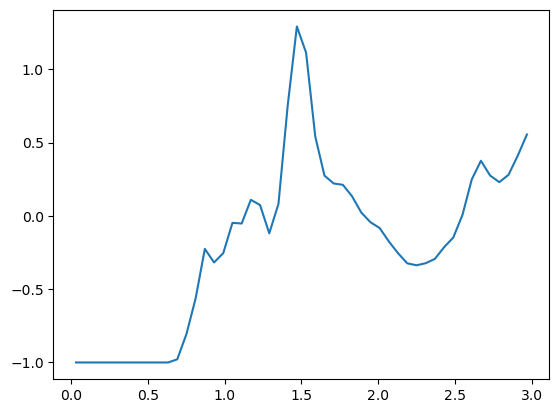

In [8]:
plt.plot(distances,perfil)

## hago el perfil con particules/subhalos

In [9]:
file = h5py.File('/mnt/projects/bias_mock/galaxies/galpos_RedSample_2e-04.hdf5','r')
pos = file['Subhalo/SubhaloPos'][()]

npart = len(pos)
rhomean = npart/lbox**3

In [10]:
def profile(x,y,z,r,grid,bines,bineado, particles = None ):
    
    if particles is None:
        particles = np.zeros(bines)
    
    for i in np.arange(bines):
        rmin = bineado[i]*r
        rmax = bineado[i+1]*r
        
        shell_dist, shell_ind = grid.shell_neighbors(
            np.array([[x,y,z]]),
            distance_lower_bound=rmin,
            distance_upper_bound=rmax
        )
        
        npar = len(shell_dist[0])
        particles[i] = npar
        
    return particles

def profile_volume(r,bines,bineado):
    
    profile = np.zeros(bines)
    cte = (4.0/3.0)*np.pi
    
    for i in np.arange(bines):
        rmin = bineado[i]*r
        rmax = bineado[i+1]*r
        
        vol = cte*(rmax**3-rmin**3)
        profile[i] = vol
        
    return profile

In [11]:
grid = gsp.GriSPy(pos, N_cells=32)
periodic = {0: (0, lbox), 1: (0, lbox), 2: (0, lbox)}
grid.set_periodicity(periodic, inplace=True)

In [12]:
perfil_points = profile(x,y,z,r,grid,bines,bineado)
volumen = profile_volume(r,bines,bineado)
delta = ((perfil_points/volumen)-rhomean)/rhomean

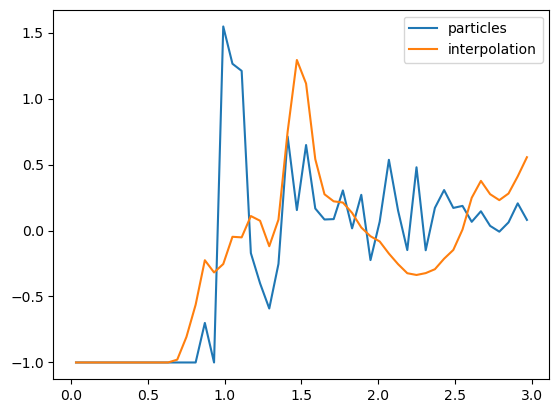

In [13]:
plt.plot(distances,delta,label='particles')
plt.plot(distances,perfil,label='interpolation')
plt.legend()

In [85]:
distances

array([0.03, 0.09, 0.15, 0.21, 0.27, 0.33, 0.39, 0.45, 0.51, 0.57, 0.63,
       0.69, 0.75, 0.81, 0.87, 0.93, 0.99, 1.05, 1.11, 1.17, 1.23, 1.29,
       1.35, 1.41, 1.47, 1.53, 1.59, 1.65, 1.71, 1.77, 1.83, 1.89, 1.95,
       2.01, 2.07, 2.13, 2.19, 2.25, 2.31, 2.37, 2.43, 2.49, 2.55, 2.61,
       2.67, 2.73, 2.79, 2.85, 2.91, 2.97])

## Ver la convergencia de el numero de minimo de bines en las esferas para calcular los perfiles

In [86]:
def numero_de_puntos_prueba(distance, nmin):
    
    if distance < 1:
        p = nmin
    if distance >= 1:    
        p = int(nmin * 13 * distance ** 2) #el 12 viene de 4 pi
    return p

def perfil_interpolado_prueba(x, y, z, bineado, rvoid, field, bin_size, lbox,nmin):
    
    ngrid = field.shape[0]
    perfil = np.zeros(bineado.shape[0] -1 , dtype=np.float32)  # Asegúrate de que el perfil sea float32
    
    i = 0
    for radio in bineado[1:]:
        
        radio_mpc = rvoid*radio - bin_size #resto bin_size para centrar
        puntos = numero_de_puntos_prueba(radio,nmin)
        posx, posy, posz = pg.fibo_points(x, y, z, radio * rvoid, puntos, ngrid)
        #print(posx)
        field_count = []
        for j in range(puntos):
            px = posx[j]
            py = posy[j]
            pz = posz[j]
            px = px % lbox
            py = py % lbox
            pz = pz % lbox
            
            pos = np.array([[px, py, pz]], dtype=np.float32)  # Asegúrate de que pos sea float32
            den = np.zeros(pos.shape[0], dtype=np.float32)
            MASL.CIC_interp(field, lbox, pos, den)
            field_count.append(den[0])
            
        #print(field_count[:5])
        perfil[i] = np.mean(field_count)
        i += 1
        
    return perfil

In [87]:
voids_grandes, = np.where(v[:,1]>50)
print(voids_grandes)

[  496   615   806  1063  1802  2098  2653  3146  3170  3377  3426  3693
  3797  5172  5252  5678  5699  5982  7334  7358  7736  8507  8636  8656
  8860  9617  9630  9743  9744 10687 10842 10929 11426 11495 11606]


In [88]:
i = 496
x = v[i,2]
y = v[i,3]
z = v[i,4]
r = v[i,1]
print(x,y,z,r)

rmin = 0
rmax = 3
bines = 50
bineado = np.linspace(rmin,rmax,bines + 1)
lbox = 1440
bin_size = lbox/field.shape[0]

10.22243499755859 763.724609375 60.07589721679688 51.63015747070312


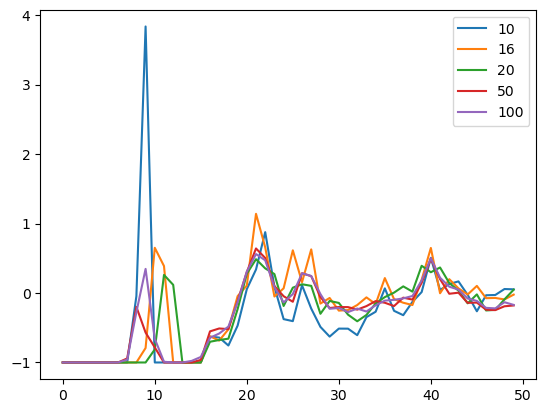

In [90]:
nmin = [10,16, 20, 50,100 ] #,500,1000,5000]
for i in nmin:
    perfil = perfil_interpolado_prueba(x, y, z, bineado, r, field, bin_size, lbox, i)
    perfil = perfil/np.mean(field) - 1
    
    plt.plot(perfil,label=str(i))
    
plt.legend()

## Chequeo numero de bines que convergan los perfiles (con CIC y con particules/subhalos)

In [91]:
i = 496
x = v[i,2]
y = v[i,3]
z = v[i,4]
r = v[i,1]
print(x,y,z,r)

nmin = 50
rmin = 0
rmax = 3
lbox = 1440
bin_size = lbox/field.shape[0]

10.22243499755859 763.724609375 60.07589721679688 51.63015747070312


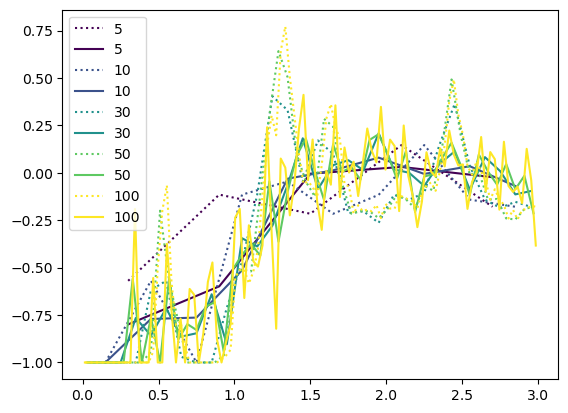

In [92]:
nbines = [5,10,30,50,100]

colores = plt.cm.viridis(np.linspace(0, 1, len(nbines)))

k = 0
for bines in nbines:

    color = colores[k]
    bineado = np.linspace(rmin,rmax,bines + 1)
    
    perfil = perfil_interpolado_prueba(x, y, z, bineado, r, field, bin_size, lbox, nmin)
    perfil = perfil/np.mean(field) - 1
    distances = bineado[1:] - (bineado[1]-bineado[0])/2
    plt.plot(distances,perfil,label=str(bines),ls='dotted', color=color)
    
    perfil_points = profile(x,y,z,r,grid,bines,bineado)
    volumen = profile_volume(r,bines,bineado)
    delta = ((perfil_points/volumen)-rhomean)/rhomean
    
    plt.plot(distances,delta,label=str(bines),color=color)
    k = k + 1
    
plt.legend()

## Chequeo como afecta a los perfiles el numero de grides del field

In [93]:
mass = '2e-04'
path = '/mnt/projects/bias_mock/galaxies/'
filename = 'galpos_RedSample_'+mass
file = h5py.File(path+filename+'.hdf5','r')
pos = file['Subhalo/SubhaloPos'][()]

In [94]:
grid    = 540  #the 3D field will have grid x grid x grid voxels
BoxSize = 1440.0 #Mpc/h ; size of box
MAS     = 'CIC'  #mass-assigment scheme
verbose = True   #print information on progress

In [95]:
delta_pyl = np.zeros((grid,grid,grid), dtype=np.float32)
MASL.MA(pos, delta_pyl, BoxSize, MAS, verbose=verbose)

bin_size = BoxSize/grid
delta_pyl = delta_pyl/(bin_size**3)


Using CIC mass assignment scheme
Time taken = 0.087 seconds



In [96]:
i = 44
x = v[i,2]
y = v[i,3]
z = v[i,4]
r = v[i,1]
print(x,y,z,r)

bines = 30
nmin = 50
rmin = 0
rmax = 3
lbox = 1440

bineado = np.linspace(rmin,rmax,bines + 1)

1308.473022460938 756.8357543945312 0.504575252532959 21.67148399353027


In [97]:
grid = gsp.GriSPy(pos, N_cells=32)
periodic = {0: (0, lbox), 1: (0, lbox), 2: (0, lbox)}
grid.set_periodicity(periodic, inplace=True)

perfil_points = profile(x,y,z,r,grid,bines,bineado)
volumen = profile_volume(r,bines,bineado)
rhomean = len(pos)/1440**3
delta = ((perfil_points/volumen)-rhomean)/rhomean

In [98]:
from scipy.ndimage import median_filter

def running_median(data, window_size):
    if window_size % 2 == 0:
        window_size += 1  # La ventana debe ser de tamaño impar
    return median_filter(data, size=window_size, mode='reflect')

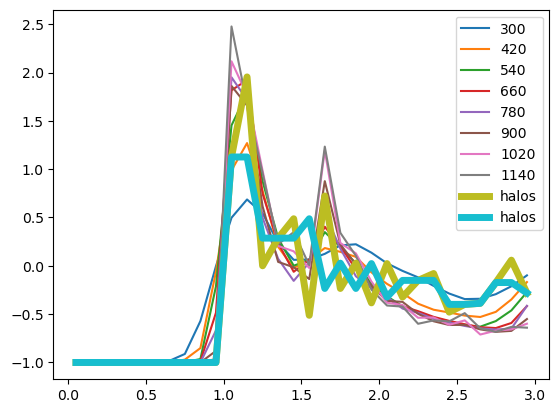

In [99]:
grides = [300, 420, 540, 660, 780, 900, 1020, 1140]

for grid in grides:
    
    # creo grid
    delta_pyl = np.zeros((grid,grid,grid), dtype=np.float32)
    MASL.MA(pos, delta_pyl, BoxSize, 'CIC', verbose=False)
    
    bin_size = lbox/delta_pyl.shape[0]
    delta_pyl = delta_pyl/(bin_size**3)
    
    perfil = perfil_interpolado_prueba(x, y, z, bineado, r, delta_pyl, bin_size, lbox, nmin)
    perfil = perfil/np.mean(delta_pyl) - 1
    distances = bineado[1:] - (bineado[1]-bineado[0])/2
    plt.plot(distances,perfil,label=str(grid))
    
    #perfil_points = profile(x,y,z,r,grid,bines,bineado)
    #volumen = profile_volume(r,bines,bineado)
    #delta = ((perfil_points/volumen)-rhomean)/rhomean
    
    
plt.plot(distances,delta,label='halos',lw=5)    
plt.plot(distances,running_median(delta,3),label='halos',lw=5)    
plt.legend()

# Chequeo si las estimaciones de la delta integrada son consistentes

### primero mi perfil de densidad (es decir de rho)


In [100]:
i = 448
x = v[i,2]
y = v[i,3]
z = v[i,4]
r = v[i,1]
print(x,y,z,r)

bines = 100
nmin = 50
rmin = 0
rmax = 3
lbox = 1440

bineado = np.linspace(rmin,rmax,bines + 1)
distances = bineado[1:] - (bineado[1]-bineado[0])/2

1101.689208984375 183.5187072753906 61.11635208129883 39.17304229736328


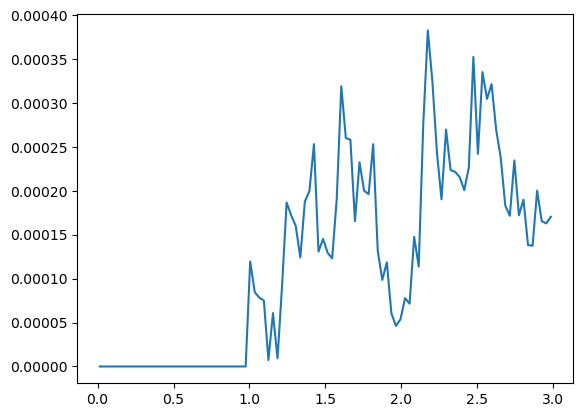

In [101]:
# primero mi perfil de densidad (es decir de rho)
perfil = perfil_interpolado_prueba(x, y, z, bineado, r, delta_pyl, bin_size, lbox, nmin)
plt.plot(distances,perfil)

In [32]:
bineado

array([0.  , 0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.3 ,
       0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.51, 0.54, 0.57, 0.6 , 0.63,
       0.66, 0.69, 0.72, 0.75, 0.78, 0.81, 0.84, 0.87, 0.9 , 0.93, 0.96,
       0.99, 1.02, 1.05, 1.08, 1.11, 1.14, 1.17, 1.2 , 1.23, 1.26, 1.29,
       1.32, 1.35, 1.38, 1.41, 1.44, 1.47, 1.5 , 1.53, 1.56, 1.59, 1.62,
       1.65, 1.68, 1.71, 1.74, 1.77, 1.8 , 1.83, 1.86, 1.89, 1.92, 1.95,
       1.98, 2.01, 2.04, 2.07, 2.1 , 2.13, 2.16, 2.19, 2.22, 2.25, 2.28,
       2.31, 2.34, 2.37, 2.4 , 2.43, 2.46, 2.49, 2.52, 2.55, 2.58, 2.61,
       2.64, 2.67, 2.7 , 2.73, 2.76, 2.79, 2.82, 2.85, 2.88, 2.91, 2.94,
       2.97, 3.  ])

In [102]:
perfil_Delta = np.zeros(len(perfil))
nhalos_tot = 0
for i in range(len(distances)):
    rmin = bineado[i]*r             # paso radio a Mpc
    rmax = bineado[i+1]*r
    vol = (4/3)*np.pi*(rmax**3 - rmin**3)
    nhalos = perfil[i]*vol     
    nhalos_tot += nhalos
    perfil_Delta[i] = nhalos_tot/((4/3)*np.pi*(rmax**3))
    
perfil_Delta = perfil_Delta/np.mean(delta_pyl) - 1

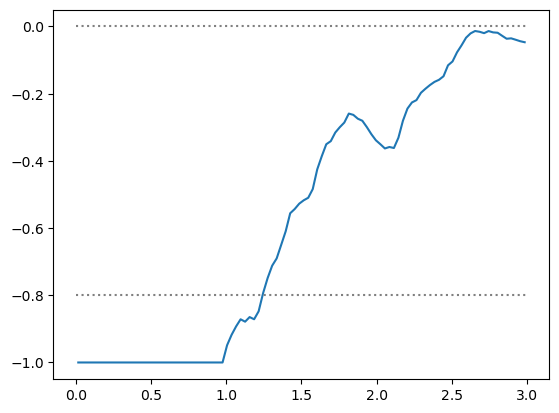

In [103]:
plt.plot(distances, perfil_Delta)
plt.hlines(y=0,xmin = 0, xmax=3,color='grey',ls='dotted')
plt.hlines(y=-0.8,xmin = 0, xmax=3,color='grey',ls='dotted')

### ahora el perfil de particulas/halos

In [104]:
grid = gsp.GriSPy(pos, N_cells=32)
periodic = {0: (0, lbox), 1: (0, lbox), 2: (0, lbox)}
grid.set_periodicity(periodic, inplace=True)

perfil_points = profile(x,y,z,r,grid,bines,bineado)
volumen = profile_volume(r,bines,bineado)
rho_halos = perfil_points/volumen

In [105]:
perfil_Delta_halos = np.zeros(len(distances))
nhalos_tot = 0
for i in range(len(distances)):
    rmin = bineado[i]*r
    rmax = bineado[i+1]*r
    nhalos = perfil_points[i]   
    nhalos_tot += nhalos
    perfil_Delta_halos[i] = nhalos_tot/((4/3)*np.pi*(rmax**3))
    
    
rhomean_halos = len(pos)/(BoxSize**3)
perfil_Delta_halos = perfil_Delta_halos/rhomean_halos - 1

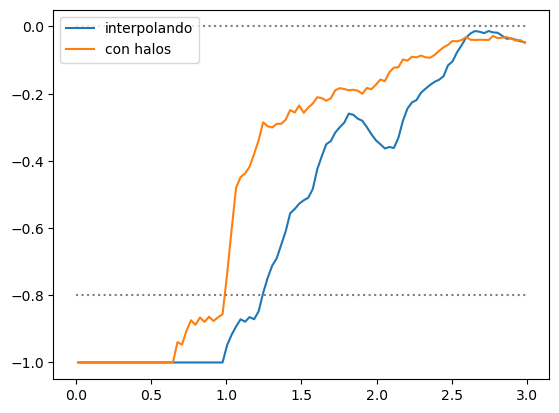

In [106]:
plt.plot(distances, perfil_Delta, label='interpolando')
plt.plot(distances, perfil_Delta_halos,label='con halos')
plt.hlines(y=0,xmin = 0, xmax=3,color='grey',ls='dotted')
plt.hlines(y=-0.8,xmin = 0, xmax=3,color='grey',ls='dotted')
plt.legend()

## Ahora comparo los perfiles con la manera rustica (asignando toda la masa a una celda)

In [107]:
#field = delta
prof, particles = pg.profile_bias(x,y,z,r,delta_pyl,bines,bineado,lbox)

In [108]:
perfil_old = prof/particles

In [109]:
perfil_Delta_old = np.zeros(len(perfil_old))
nhalos_tot = 0
for i in range(len(distances)):
    rmin = bineado[i]*r             # paso radio a Mpc
    rmax = bineado[i+1]*r
    vol = (4/3)*np.pi*(rmax**3 - rmin**3)
    nhalos = perfil_old[i]*vol     
    nhalos_tot += nhalos
    perfil_Delta_old[i] = nhalos_tot/((4/3)*np.pi*(rmax**3))
    
perfil_Delta_old = perfil_Delta_old/np.mean(delta_pyl) - 1

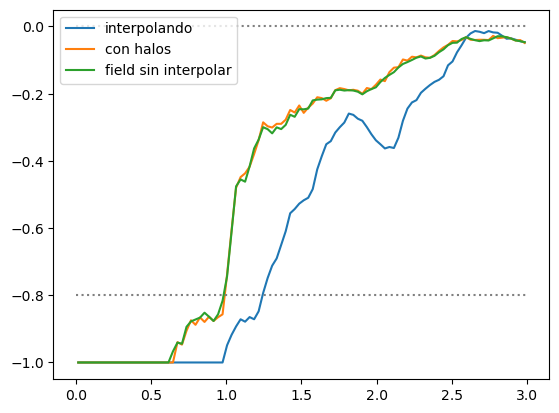

In [110]:
plt.plot(distances, perfil_Delta, label='interpolando')
plt.plot(distances, perfil_Delta_halos,label='con halos')
plt.plot(distances, perfil_Delta_old, label='field sin interpolar')
plt.hlines(y=0,xmin = 0, xmax=3,color='grey',ls='dotted')
plt.hlines(y=-0.8,xmin = 0, xmax=3,color='grey',ls='dotted')
plt.legend()

# Chequeo numero de bines

In [111]:
rmin = 0
rmax = 3
bines = 30
bineado = np.linspace(rmin,rmax,bines + 1)
lbox = 1440
bin_size = lbox/field.shape[0]

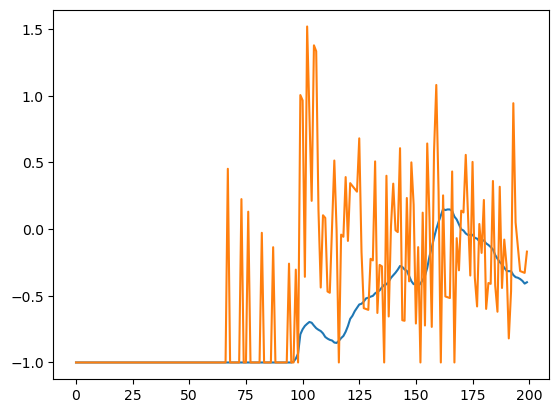

In [112]:
rmin = 0
rmax = 2
bines = 200
bineado = np.linspace(rmin,rmax,bines + 1)
lbox = 1440
bin_size = lbox/field.shape[0]

perfil = perfil_interpolado(x, y, z, bineado, r, field, bin_size, lbox)
perfil = perfil/np.mean(field) - 1
plt.plot(perfil)

perfil_points = profile(x,y,z,r,grid,bines,bineado)
volumen = profile_volume(r,bines,bineado)
delta_part = ((perfil_points/volumen)-rhomean)/rhomean
plt.plot(delta_part)

# Chequeo si el fibo points depende de la fase

In [113]:
def fibo_points(x0,y0,z0,d,nsamples,ngrid, fase = None):
        
    if fase == None:
        fase = 0
        
    x = []
    y = []
    z = []
    
    
    offset = 2.0 / (nsamples);                                                                                                                                                
    increment = np.pi * (3.0 - np.sqrt(5.0));                                                                                                                                              
    
    for i in range(nsamples):
        yt = ((i * offset) - 1) + (offset / 2);                                                                                                                                             
        r = np.sqrt(1 - yt * yt)*d;                                                                                                                                                          
        phi = ((i + 1) % nsamples) * increment + fase;                                                                                                                                        
        x.append(np.cos(phi) * r )                                                                                                                                                                 
        y.append(yt)
        z.append(np.sin(phi) * r)
        
    return np.array(x)+x0,np.array(y)+y0,np.array(z)+z0

In [114]:
x1,y1,z1 = fibo_points(0,0,0,1,1000,100,0)
x2,y2,z2 = fibo_points(0,0,0,1,1000,100,np.pi)

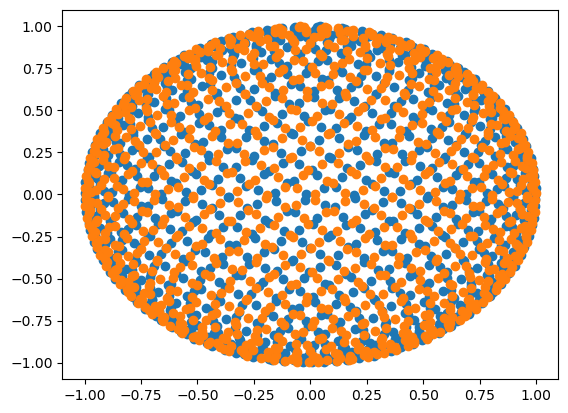

In [115]:
plt.plot(x1,y1,ls='none',marker='o')
plt.plot(x2,y2,ls='none',marker='o')

In [116]:
i = 35
x = v[i,2]
y = v[i,3]
z = v[i,4]
r = v[i,1]
print(x,y,z,r)

465.7067565917969 607.3328247070312 3.515418529510498 30.80181312561035


In [117]:
fase = random.random()*np.pi
fase

2.34276245277474

In [121]:
import random

def perfil_interpolado_random_fase(x, y, z, bineado, rvoid, field, bin_size, lbox):
    
    ngrid = field.shape[0]
    perfil = np.zeros(bineado.shape[0] -1 , dtype=np.float32)  # Asegúrate de que el perfil sea float32
    
    i = 0
    for radio in bineado[1:]:
        
        radio_mpc = rvoid*radio - bin_size #resto bin_size para centrar
        puntos = numero_de_puntos(radio)
        fase = random.random()*np.pi 
        posx, posy, posz = fibo_points(x, y, z, radio * rvoid, puntos, ngrid, fase)
        field_count = []
        for j in range(puntos):
            px = posx[j]
            py = posy[j]
            pz = posz[j]
            px = px % lbox
            py = py % lbox
            pz = pz % lbox
            #px = pg.correct_positions_periodicity(px, lbox)
            #py = pg.correct_positions_periodicity(py, lbox)
            #pz = pg.correct_positions_periodicity(pz, lbox)
            
            
            # px,py,pz pueden ser negativos, CORREGIR !!!
            pos = np.array([[px, py, pz]], dtype=np.float32)  # Asegúrate de que pos sea float32
            den = np.zeros(pos.shape[0], dtype=np.float32)
            

            MASL.CIC_interp(field, lbox, pos, den)
            field_count.append(den[0])
            
        
        perfil[i] = np.mean(field_count)
        i += 1
        
    
    return perfil

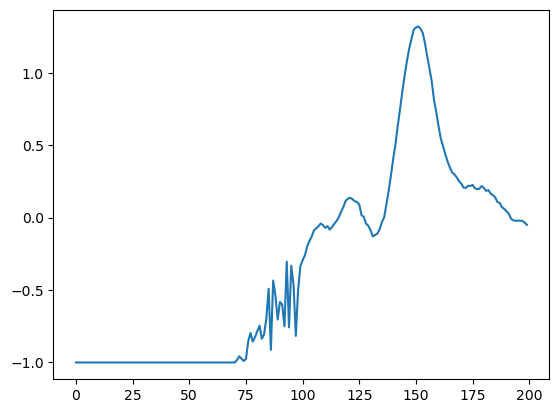

In [122]:
perfil = perfil_interpolado_random_fase(x, y, z, bineado, r, field, bin_size, lbox)
perfil = perfil/np.mean(field) - 1

plt.plot(perfil)

#perfil = perfil_interpolado_random_fase(x, y, z, bineado, r, field, bin_size, lbox)
#perfil = perfil/np.mean(field) - 1

#plt.plot(perfil)

In [123]:
pos = np.array([[465.6,606.3,3.2]], dtype=np.float32)
den = np.zeros(pos.shape[0], dtype=np.float32)
MASL.CIC_interp(field, lbox, pos, den)

In [124]:
binx = int(465.6/2.66)
biny = int(606.3/2.66)
binz = int(3.2/2.66)
field[binx-1,biny-1,binz-1]

0.0

In [19]:
from icosphere import icosphere
nu = 36  # or any other integer
vertices, faces = icosphere(nu)

In [126]:
vertices.shape

(12962, 3)

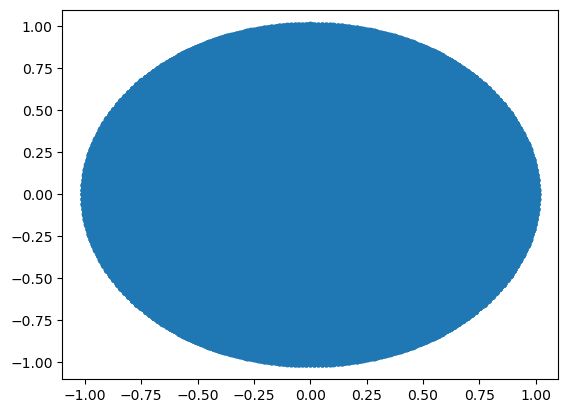

In [127]:
plt.plot(vertices[:,0],vertices[:,1],ls='none',marker='o')

In [14]:
def perfil_interpolado_icosphere(x, y, z, bineado, rvoid, field, bin_size, lbox):
    
    ngrid = field.shape[0]
    perfil = np.zeros(bineado.shape[0] -1 , dtype=np.float32)  # Asegúrate de que el perfil sea float32
    
    i = 0
    for radio in bineado[1:]:
        
        radio_mpc = rvoid*radio - bin_size #resto bin_size para centrar
        
        if radio < 4:
            nu = 2
        if radio >= 4:
            nu = 40
            
        posx, posy, posz = icosphere_points(x, y, z, radio_mpc, nu)
        puntos = len(posx)
        field_count = []
        asd = 0
        for j in range(puntos):
            px = posx[j]
            py = posy[j]
            pz = posz[j]
            px = px % lbox
            py = py % lbox
            pz = pz % lbox
            
            #px = pg.correct_positions_periodicity(px, lbox)
            #py = pg.correct_positions_periodicity(py, lbox)
            #pz = pg.correct_positions_periodicity(pz, lbox)
            
            
            # px,py,pz pueden ser negativos, CORREGIR !!!
            
            pos = np.array([[px, py, pz]], dtype=np.float32)  # Asegúrate de que pos sea float32
            den = np.zeros(pos.shape[0], dtype=np.float32)
            MASL.CIC_interp(field, lbox, pos, den)
            field_count.append(den[0])
            
            
        
        perfil[i] = np.mean(field_count)
        i += 1
        
    print(len(field_count))
    return perfil

In [ ]:
bines

In [17]:
def icosphere_points(x0,y0,z0,r,nu):
        
    x = []
    y = []
    z = []
    
    vertices, faces = icosphere(nu)
    x = vertices[:,0]*r
    y = vertices[:,1]*r
    z = vertices[:,2]*r
        
    return np.array(x)+x0,np.array(y)+y0,np.array(z)+z0

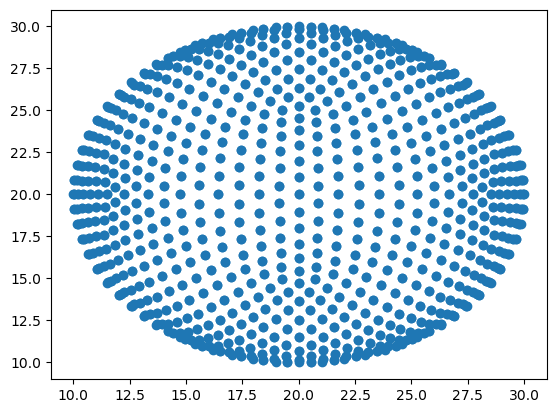

In [20]:
posx, posy, posz = icosphere_points(20, 20, 20, 10, 12)
plt.plot(posx,posy,ls='none',marker='o')

In [191]:
i = 13
x = v[i,2]
y = v[i,3]
z = v[i,4]
r = v[i,1]

rmin = 0
rmax = 3
bines = 25
bineado = np.linspace(rmin,rmax,bines + 1)

In [192]:
smooth = 1
field_name = 'galpos_RedSample_2e-04_CIC_Top-Hat_rscale_'+str(smooth)
field_name = 'rho_2e-04_CIC'
field = np.load('/mnt/projects/bias_mock/galaxies/smoothed_fields/'+field_name+'.npy').astype(np.float32)
#field = field/np.mean(field) - 1
#field_name = 'density_field_mio'
#field = np.load(field_name+'.npy').astype(np.float32)  # Convertir a float32
#v = np.loadtxt('/home/arodriguez/BACCO/bias-voids/void_finder/voids_2e-04_smooth_'+str(smooth)+'_clean_-0.8_parallel.dat',skiprows=1,delimiter=',')
v = np.loadtxt('/mnt/projects/bias_mock/voids/sphvds_raul-RedSample_2e-04-0.8.dat')


mass = '2e-04'
path = '/mnt/projects/bias_mock/galaxies/'
filename = 'galpos_RedSample_'+mass
file = h5py.File(path+filename+'.hdf5','r')
pos = file['Subhalo/SubhaloPos'][()]

grid = gsp.GriSPy(pos, N_cells=32)
periodic = {0: (0, lbox), 1: (0, lbox), 2: (0, lbox)}
grid.set_periodicity(periodic, inplace=True)

42


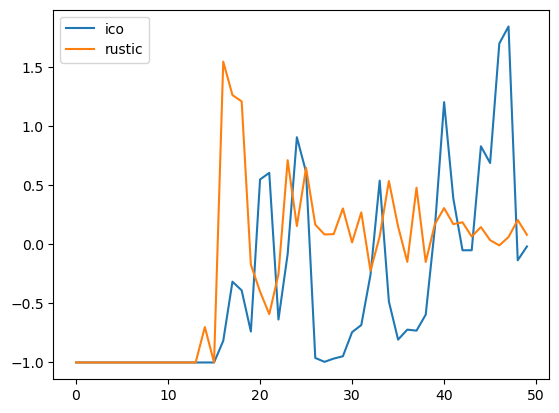

In [21]:
perfil = perfil_interpolado_icosphere(x, y, z, bineado, r, field, bin_size, lbox)
perfil = perfil/np.mean(field) - 1

plt.plot(perfil,label='ico')

perfil_points = profile(x,y,z,r,grid,bines,bineado)
volumen = profile_volume(r,bines,bineado)
delta = ((perfil_points/volumen)-rhomean)/rhomean
plt.plot(delta,label='rustic')
plt.legend()

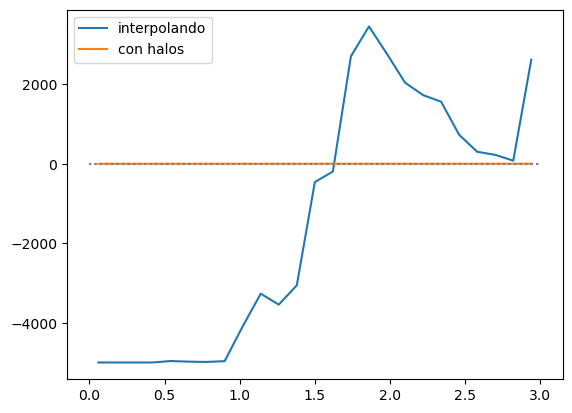

In [198]:
distances = bineado[1:] - (bineado[1]-bineado[0])/2

perfil_Delta = np.zeros(len(perfil))
nhalos_tot = 0
for i in range(len(distances)):
    rmin = bineado[i]*r             # paso radio a Mpc
    rmax = bineado[i+1]*r
    vol = (4/3)*np.pi*(rmax**3 - rmin**3)
    nhalos = perfil[i]*vol     
    nhalos_tot += nhalos
    perfil_Delta[i] = nhalos_tot/((4/3)*np.pi*(rmax**3))
    
perfil_Delta = perfil_Delta/np.mean(delta_pyl) - 1

perfil_Delta_halos = np.zeros(len(distances))
nhalos_tot = 0
for i in range(len(distances)):
    rmin = bineado[i]*r
    rmax = bineado[i+1]*r
    nhalos = perfil_points[i]   
    nhalos_tot += nhalos
    perfil_Delta_halos[i] = nhalos_tot/((4/3)*np.pi*(rmax**3))
    
    
rhomean_halos = len(pos)/(BoxSize**3)
perfil_Delta_halos = perfil_Delta_halos/rhomean_halos - 1

plt.plot(distances, perfil_Delta, label='interpolando')
plt.plot(distances, perfil_Delta_halos,label='con halos')
plt.hlines(y=0,xmin = 0, xmax=3,color='grey',ls='dotted')
plt.hlines(y=-0.8,xmin = 0, xmax=3,color='grey',ls='dotted')
plt.legend()